In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage.interpolation import shift
import os
import seaborn as sns
import json
import re

from pdftabextract.common import read_xml, parse_pages
from pdftabextract.clustering import zip_clusters_and_values
from pdftabextract.textboxes import border_positions_from_texts, split_texts_by_positions, join_texts
from pdftabextract.common import all_a_in_b, DIRECTION_VERTICAL
from pdftabextract.clustering import find_clusters_1d_break_dist
from pdftabextract.clustering import calc_cluster_centers_1d
from pdftabextract.extract import make_grid_from_positions
from pdftabextract.extract import fit_texts_into_grid, datatable_to_dataframe

from tabula import read_pdf
import pandas as pd

%matplotlib inline

In [2]:
from tables_detector.tables_detector import TableDetector

In [3]:

dat_path = "../../../dat/DATASETS/NL 14614829 - Claim File- image 1_Part 1/Output"
#dat_path = "../../../dat"

In [4]:
#pdf_file_name = 'Confirmation of  Coverage - 1.pdf'
pdf_file_name = 'Accident-Handwritten_V3.pdf'
#pdf_file_name = 'Accident Claim - 2[1406].pdf'
#pdf_file_name = 'Deidentified medical record.pdf'
#pdf_file_name = 'EgyptJHaematol_2012_37_4_207_134966_5.pdf'

base_file_name = os.path.splitext(pdf_file_name)[0]
page_num = 1
# Convert pdf to tiff
print('Conversion started')
#cmd = 'convert -density 300 ' + pdf_file_name + '[' + str(page_num-1) + ']' + ' -resize 250% ' + base_file_name+'.tiff'
cmd = 'convert -density 300 ' + re.escape(pdf_file_name) + '[' + str(page_num-1) + ']' + ' ' + re.escape(base_file_name)+'.tiff'
#cmd = 'convert -density 150 ' + pdf_file_name + ' ' + base_file_name+'.tiff'
os.system(cmd)
print('Conversion done')

#base_file_name = 'Page 1'
# Convert tiff to pdf sandwitch
cmd = 'tesseract' + ' ' + re.escape(base_file_name)+'.tiff' + ' ' + re.escape(base_file_name)+'_pdf_sand' + ' pdf'
#cmd = 'tesseract' + ' ' + 'Page 3.tiff' + ' ' + base_file_name+'_pdf_sand' + ' pdf'
os.system(cmd)

# Convert pdf sandwitch to xml
xml_file = base_file_name+'.xml'
pdf_sand_file_name = base_file_name+'_pdf_sand.pdf'
cmd = 'pdftohtml -c -hidden -xml' + ' ' + re.escape(pdf_sand_file_name) + ' ' + re.escape(xml_file)
os.system(cmd)


Conversion started
Conversion done


0

In [5]:
'''
# Convert tiff to pdf sandwitch
base_file_name = 'Page 1'
# Convert tiff to pdf sandwitch
cmd = 'tesseract' + ' ' + re.escape(base_file_name)+'.tiff' + ' ' + re.escape(base_file_name)+'_pdf_sand' + ' pdf'
#cmd = 'tesseract' + ' ' + 'Page 3.tiff' + ' ' + base_file_name+'_pdf_sand' + ' pdf'
os.system(cmd)

# Convert pdf sandwitch to xml
xml_file = base_file_name+'.xml'
pdf_sand_file_name = base_file_name+'_pdf_sand.pdf'
cmd = 'pdftohtml -c -hidden -xml' + ' ' + re.escape(base_file_name)+'_pdf_sand.pdf' + ' ' + re.escape(xml_file)
os.system(cmd)
'''

"\n# Convert tiff to pdf sandwitch\nbase_file_name = 'Page 1'\n# Convert tiff to pdf sandwitch\ncmd = 'tesseract' + ' ' + re.escape(base_file_name)+'.tiff' + ' ' + re.escape(base_file_name)+'_pdf_sand' + ' pdf'\n#cmd = 'tesseract' + ' ' + 'Page 3.tiff' + ' ' + base_file_name+'_pdf_sand' + ' pdf'\nos.system(cmd)\n\n# Convert pdf sandwitch to xml\nxml_file = base_file_name+'.xml'\npdf_sand_file_name = base_file_name+'_pdf_sand.pdf'\ncmd = 'pdftohtml -c -hidden -xml' + ' ' + re.escape(base_file_name)+'_pdf_sand.pdf' + ' ' + re.escape(xml_file)\nos.system(cmd)\n"

In [6]:
#!python3 -m http.server 8080 --bind 127.0.0.1

 http://127.0.0.1:8080/pdf2xml-viewer.html.

In [7]:
!ls


 0e521b72-651c-4a00-b4b8-2803d3b.pdf
 0e521b72-651c-4a00-b4b8-2803d3b91f79_1.tiff
 0e521b72-651c-4a00-b4b8-2803d3b91f79_1.tiff_table.jpg
 0e521b72-651c-4a00-b4b8-2803d3b91f79_1.xml
 3.tiff.pdf
'Accident Claim - 2[1406]-1_1.jpg'
'Accident Claim - 2[1406]-2_1.jpg'
'Accident Claim - 2[1406]-3_1.jpg'
'Accident Claim - 2[1406]-4_1.jpg'
'Accident Claim - 2[1406]-5_1.jpg'
'Accident Claim - 2[1406].json'
'Accident Claim - 2[1406].pdf'
'Accident Claim - 2[1406].tiff'
'Accident Claim - 2[1406].tiff_table.jpg'
'Accident Claim - 2[1406].xml'
'Accident Claim - 2[1406]_pdf_sand.pdf'
 Accident-Handwritten_V3-1_1.jpg
 Accident-Handwritten_V3-1_1.jpg_table.jpg
 Accident-Handwritten_V3-1_1.png
 Accident-Handwritten_V3-2_1.jpg
 Accident-Handwritten_V3-3_1.jpg
 Accident-Handwritten_V3-3_1.jpg_table.jpg
 Accident-Handwritten_V3.json
 Accident-Handwritten_V3.pdf
 Accident-Handwritten_V3.tiff
 Accident-Handwritten_V3.tiff_table.jpg
 Accident-Handwritten_V3.xml
 Accident-Handwritten_V3_pdf_sand.pdf
 Accident-

In [8]:
#file_name = '0e521b72-651c-4a00-b4b8-2803d3b91f79_1.tiff'
#xml_file = '0e521b72-651c-4a00-b4b8-2803d3b91f79_1.xml'
#pdf_file_name = 'Accident Claim - 2[1406].pdf'
#base_file_name = 'Accident Claim - 2[1406]'
file_name = base_file_name+'.tiff'
#xml_file = base_file_name+'.xml'


#file_name = 'Page 1.tiff'
#xml_file = 'Page 1.xml'

#file_name = 'Page 3.jpg' # OK
#file_name = 'Page 5.jpg' # OK
#file_name = 'Page 7.jpg' # OK
#file_name = 'Page 8.jpg' # NOK
#file_name = 'Page 3.tiff' # NOK
#file_name = 'Page 3_mod.tiff' # NOK
#file_name = 'Page 3_mod_no_table.tiff' # NOK
#img_orig = cv2.imread(os.path.join(dat_path, file_name), 0)
img_orig = cv2.imread(file_name, 0)
img_orig = cv2.threshold(img_orig, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
img = (255 - img_orig.copy())/255
img = img[:, :-100]


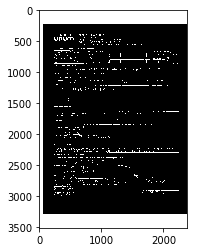

In [9]:
plt.imshow(img,cmap='gray')

In [10]:
img.shape

(3508, 2379)

In [11]:
'''
#img_new = cv2.resize(img, (img.shape[0], img.shape[1] + 100))
img_new = np.zeros((img.shape[0], img.shape[1] + 100))
img_new[:, 100:] = img
#img_new = np.concatenate(np.zeros((img.shape[0], 100)), img)
plt.imshow(img_new,cmap='gray')
img = img_new.copy()
'''

"\n#img_new = cv2.resize(img, (img.shape[0], img.shape[1] + 100))\nimg_new = np.zeros((img.shape[0], img.shape[1] + 100))\nimg_new[:, 100:] = img\n#img_new = np.concatenate(np.zeros((img.shape[0], 100)), img)\nplt.imshow(img_new,cmap='gray')\nimg = img_new.copy()\n"

> Grid with 9 rows, 2 columns
> Grid with 3 rows, 4 columns
> Grid with 1 rows, 2 columns
> Grid with 4 rows, 2 columns
> Grid with 1 rows, 2 columns


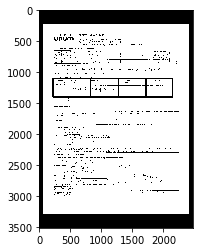

'{"data": [{"0": {"0": "Dates of Diagnosis", "1": "Service (including Code (ICD);", "2": "Confinement)"}, "1": {"0": "Diagnosis Description", "1": "", "2": ""}, "2": {"0": "Procedure}", "1": "", "2": ""}, "3": {"0": "\\u201d Procedure Description", "1": "", "2": ""}}]}'

In [12]:
verbose = False
# 3508x2379 ~ 90linesx25words ~ pixels/word = 96, pixels/line=40--> strip_height > 40 (*2 for header usually > 2 lines) (100) w_max_pool < 96 (50)
tables_detector = TableDetector(verbose, strip_height=50, w_max_pool=75, min_col_width=250, ratio_clip_max=0.25)
#tables_detector = TableDetector(verbose, strip_height=50, w_max_pool=50, min_col_width=100, ratio_clip_max=0.25)
tables = tables_detector.detect_tables(img)

tables_detector.fit_text_to_tables(xml_file)
tables_detector.visualize_tables(img_orig, file_name)
#tables_detector.save_json(base_file_name)
list_of_json_tables = tables_detector.get_tables_in_json()
json.dumps({"data": list_of_json_tables})

In [13]:
list_of_json_tables

[{'0': {'0': 'Dates of Diagnosis',
   '1': 'Service (including Code (ICD);',
   '2': 'Confinement)'},
  '1': {'0': 'Diagnosis Description', '1': '', '2': ''},
  '2': {'0': 'Procedure}', '1': '', '2': ''},
  '3': {'0': '” Procedure Description', '1': '', '2': ''}}]

In [14]:
tables_detector.tables

[{'table_start': 1100,
  'col_positions': array([ 224,  824, 1274, 1724, 2155]),
  'table_end': 1400}]

In [15]:
coordinates = []
for table in tables_detector.tables:
    #json.loads(table.to_json().encode('utf-8').decode('utf-8'))
    coordinates.append({'x1': int(table['col_positions'][0]), 'y1':int(table['table_start']) , 'x2':int(table['col_positions'][-1]),'y2': int(table['table_end'])})


In [16]:
coordinates

[{'x1': 224, 'y1': 1100, 'x2': 2155, 'y2': 1400}]

In [17]:
json.dumps({"data": list_of_json_tables, "coordinates": coordinates})

'{"data": [{"0": {"0": "Dates of Diagnosis", "1": "Service (including Code (ICD);", "2": "Confinement)"}, "1": {"0": "Diagnosis Description", "1": "", "2": ""}, "2": {"0": "Procedure}", "1": "", "2": ""}, "3": {"0": "\\u201d Procedure Description", "1": "", "2": ""}}], "coordinates": [{"x1": 224, "y1": 1100, "x2": 2155, "y2": 1400}]}'

In [18]:
df = tables_detector.tables_df[0]
df

,0,1,2,3
0,Dates of Diagnosis,Diagnosis Description,Procedure},” Procedure Description
1,Service (including Code (ICD);,,,
2,Confinement),,,


In [20]:
len(df)

3

In [19]:
'''
def format_JSON(tables_df, coordinates):
    tables_JSON = []
    for i, table in enumerate(tables_df):
        table_JSON = {}
        table_JSON['Id'] = i
        table_JSON['row_count'] = len(table)
        table_JSON['col_count'] = 
        table_JSON['coordinates'] = coordinates[i]
        table_JSON['data'] = 
        
        table_df = pd.DataFrame('Id', 'row_count', 'col_count', 'coordinates', 'data')
        tables_JSON.append(table_JSON)
'''

SyntaxError: invalid syntax (<ipython-input-19-0a20b6eb4ba4>, line 6)

In [ ]:
'''
df = tables_detector.tables_df[0]
idx = range(len(df.columns))
new_names = []
for i in range(len(df.columns)):
    new_names.append(str(i))
new_names
df.columns = new_names
'''

In [ ]:
df

In [ ]:

df_tabula = read_pdf(pdf_sand_file_name)# If tables with lines, better use tabula 

try:
    df_tabula.to_json(base_file_name+'.json')
    #list_of_json_tables = [json.loads(df_tabula.to_json())]
    list_of_json_tables = read_pdf(pdf_file_name, pages="1", output_format="json")
    
except:
    verbose = False
    # 3508x2379 ~ 90linesx25words ~ pixels/word = 96, pixels/line=40--> strip_height > 40 (*2 for header usually > 2 lines) (100) w_max_pool < 96 (50)
    tables_detector = TableDetector(verbose, strip_height=50, w_max_pool=75, min_col_width=250, ratio_clip_max=0.25)
    tables = tables_detector.detect_tables(img)
    tables_detector.visualize_tables(img_orig, file_name)
    tables_detector.fit_text_to_tables(xml_file)
    #tables_detector.save_json(base_file_name)
    list_of_json_tables = tables_detector.get_tables_in_json()
    
json.dumps({"data": list_of_json_tables})

In [ ]:
list_of_json_tables

In [ ]:
df_tabula

In [ ]:
with open(base_file_name+'.json', 'w') as outfile:  
    json.dump({"data": list_of_json_tables}, outfile)